# SP simulations examining time-varying flow

In this notebook, we simulate the response where we have time-varying flow for wellbore geometry 2 from [3-plug-and-abandonment-no-casing-updated-well.ipynb](3-plug-and-abandonment-no-casing-updated-well.ipynb)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
from matplotlib import cm as colormap
from scipy.constants import foot, inch
from scipy.interpolate import interp1d
import pandas as pd

import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg import utils, maps, Report
import geoana

from pymatsolver import Pardiso

## Set up the model parameters

- all conductivity values are in units of S/m
- all length scales are in units of meters

To ignore steel, change the conductivity value of the steel to be the same as the cement. 

In [2]:
conductivity_values = {
    "background":0.07,
    "cement":0.01,
    "cement_eap": 85, 
    "sand": 0.01,
    "steel": 0.01, #5e6, 
    "very_resistive":1e-8,
    "fluid":0.05,
    "break": 0.01,
}

print("Conductivity values")
for key, val in conductivity_values.items():
    print(f"{key:15s}: {val:1.1e} S/m")


Conductivity values
background     : 7.0e-02 S/m
cement         : 1.0e-02 S/m
cement_eap     : 8.5e+01 S/m
sand           : 1.0e-02 S/m
steel          : 1.0e-02 S/m
very_resistive : 1.0e-08 S/m
fluid          : 5.0e-02 S/m
break          : 1.0e-02 S/m


In [3]:
geometry = {
    "casing_length": 11, # 122ft - 10ft packer@ bottom = 112ft
    "surface_packer_thickness": 0.5, # 1.6ft
    "bottom_seal_thickness": 3,  # 10ft
    "casing_outer_diameter": 0.6, #0.2, # 7.75in
    "casing_inner_diameter": 0.18, # 7in
    "pvc_outer_diameter": 0.04, # 1.5in
    "pvc_inner_diameter": 0.03, # 1.0in
    "break_top": 0, 
    "break_bottom": -2,
}
geometry["casing_outer_radius"] = geometry["casing_outer_diameter"] / 2
geometry["casing_inner_radius"] = geometry["casing_inner_diameter"] / 2
geometry["pvc_outer_radius"] = geometry["pvc_outer_diameter"] / 2
geometry["pvc_inner_radius"] = geometry["pvc_inner_diameter"] / 2
geometry["total_length"] = geometry["casing_length"] + geometry["bottom_seal_thickness"]

cement_depth = {
    "case_1": 9, # 50 ft
}

print("Geometry")
for key, val in geometry.items():
    print(f"{key:25s}: {val:3.2f} m")
print("\nCement depth")
for key, val in cement_depth.items():
    print(f"{key:8s}: {val:2.1f} m")

Geometry
casing_length            : 11.00 m
surface_packer_thickness : 0.50 m
bottom_seal_thickness    : 3.00 m
casing_outer_diameter    : 0.60 m
casing_inner_diameter    : 0.18 m
pvc_outer_diameter       : 0.04 m
pvc_inner_diameter       : 0.03 m
break_top                : 0.00 m
break_bottom             : -2.00 m
casing_outer_radius      : 0.30 m
casing_inner_radius      : 0.09 m
pvc_outer_radius         : 0.02 m
pvc_inner_radius         : 0.01 m
total_length             : 14.00 m

Cement depth
case_1  : 9.0 m


## compute Jsp for time varying flow

pore pressure gradient values are provided in the file [pore-pressure-gradient-short.csv](pore-pressure-gradient-short.csv)

In [4]:
rho_water = 1000
g = 10 
L = 1e-5

In [5]:
pore_pressure_grad_data = pd.read_csv("pore-pressure-grad-short.csv")
pore_pressure_grad_data.iloc[0, 1:] = 0
pore_pressure_grad_data

,Depth (m),"Grad. P (Pa/m), t=0.5 s","Grad. P (Pa/m), t=1.5 s","Grad. P (Pa/m), t=3.5 s","Grad. P (Pa/m), t=7 s","Grad. P (Pa/m), t=15 s","Grad. P (Pa/m), t=25 s"
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.609600,0.0,0.0,0.0,0.0,-3200000.0,-1100000.0
2,1.219200,0.0,0.0,0.0,0.0,-2430000.0,-934000.0
3,1.828800,0.0,0.0,0.0,-15300000.0,-1880000.0,-802000.0
4,2.438400,0.0,0.0,0.0,-9230000.0,-1490000.0,-696000.0
5,3.048000,0.0,0.0,0.0,-5830000.0,-1200000.0,-612000.0
6,3.657600,0.0,0.0,0.0,-3840000.0,-989000.0,-545000.0
7,4.267200,0.0,0.0,-16000000.0,-2640000.0,-830000.0,-490000.0
8,4.876800,0.0,0.0,-8230000.0,-1890000.0,-711000.0,-447000.0
9,5.486400,0.0,0.0,-4620000.0,-1420000.0,-622000.0,-412000.0


In [6]:
pore_pressure_cols = pore_pressure_grad_data.columns[1:]
depths = pore_pressure_grad_data["Depth (m)"].to_numpy()

In [7]:
pore_pressure_cols.to_list()

['Grad. P (Pa/m), t=0.5 s',
 'Grad. P (Pa/m), t=1.5 s',
 'Grad. P (Pa/m), t=3.5 s',
 'Grad. P (Pa/m), t=7 s',
 'Grad. P (Pa/m), t=15 s',
 'Grad. P (Pa/m), t=25 s']

In [8]:
scaling = - L / (rho_water * g) 
scaling

-1e-09

## set up interpolation functions to interpolate to the mesh

In [9]:
depths_interp = {}
interp_dict = {}
for key in pore_pressure_cols.to_list():
    grad_p = pore_pressure_grad_data[key].to_numpy()
    non_zero_inds = np.abs(grad_p) > 0
    depths_interp[key] = depths[non_zero_inds]
    interp_dict[key] = interp1d(
            depths[non_zero_inds], np.log(scaling * grad_p[non_zero_inds]), 
            fill_value=0, kind="linear", bounds_error=False
        ) 
interp_dict

{'Grad. P (Pa/m), t=0.5 s': <scipy.interpolate._interpolate.interp1d at 0x7f385fa5de50>,
 'Grad. P (Pa/m), t=1.5 s': <scipy.interpolate._interpolate.interp1d at 0x7f385fa5c040>,
 'Grad. P (Pa/m), t=3.5 s': <scipy.interpolate._interpolate.interp1d at 0x7f385fa5c1d0>,
 'Grad. P (Pa/m), t=7 s': <scipy.interpolate._interpolate.interp1d at 0x7f385fa5c360>,
 'Grad. P (Pa/m), t=15 s': <scipy.interpolate._interpolate.interp1d at 0x7f385fa5c4f0>,
 'Grad. P (Pa/m), t=25 s': <scipy.interpolate._interpolate.interp1d at 0x7f385fa5c680>}

# build a mesh

- we highly refine the mesh near the wellbore and then pad out to ensure that we satisfy boundary conditions (e.g. that the outer boundary is a few skin depths away)

In [10]:
csx = 0.0025
csz = 0.125
padding_factor = 1.1
npad_x = 120 #70 # 40
npad_z = 80 # 25

n_core_x = int(np.ceil(geometry["casing_outer_radius"]/csx))
n_core_z = int(np.ceil((geometry["total_length"])/csz))

In [11]:
mesh = discretize.CylindricalMesh(
    [
        [(csx, n_core_x), (csx, npad_x, padding_factor)],
        np.r_[2*np.pi], 
        [(csz, npad_z, -padding_factor), (csz, n_core_z), (csz, npad_z, padding_factor)]
    ]
)

mesh.origin = np.r_[0, 0, -mesh.h[2][:npad_z+n_core_z].sum()]

<AxesSubplot:xlabel='x', ylabel='z'>

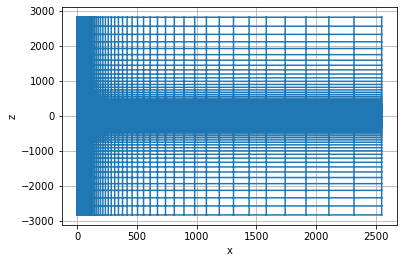

In [12]:
mesh.plot_grid()

In [13]:
print(mesh.n_cells)

65280


## interpolate jsp values to the mesh

In [14]:
jsp_vertical = {}
for key in pore_pressure_cols:
    jsp = np.zeros_like(mesh.nodes_z)
    inds_nonzero = (mesh.nodes_z > -cement_depth["case_1"]) & (mesh.nodes_z < -depths_interp[key].min())
    
    jsp[inds_nonzero] = np.exp(interp_dict[key](-mesh.nodes_z[inds_nonzero]))
    jsp_vertical[key] = jsp

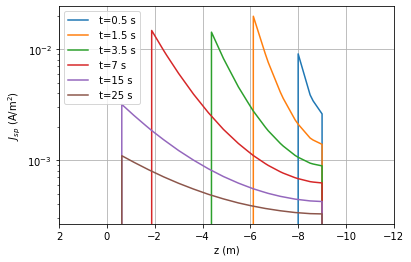

In [16]:
fig, ax = plt.subplots(1, 1)

for key in pore_pressure_cols:
    ax.semilogy(mesh.nodes_z, jsp_vertical[key], label=key.split(",")[-1])
ax.set_xlim([2, -12])
# ax.set_ylim([1e-4, 1e-1])
ax.set_xlabel("z (m)")
ax.set_ylabel("$J_{sp}$ (A/m$^2$)") 
ax.grid()
ax.legend()   

## put the model on the mesh

In [17]:
def get_model(case, eap=False, steel_conductivity=None, broken_casing=False): 
    """
    A function to put the electrical conductivity model on the mesh for each 
    of the different cases. 
    """
    
    if steel_conductivity is None: 
        steel_conductivity = conductivity_values["steel"]
    
    # initialize as background
    model = np.ones(mesh.n_cells) * conductivity_values["background"]

    # air
    model[mesh.cell_centers[:,2] > 0] = conductivity_values["very_resistive"]

    # steel casing
    inds_casing_z = (
        (mesh.cell_centers[:, 2] >= -geometry["casing_length"]) &
        (mesh.cell_centers[:, 2] <= 0)
    )
    inds_steel = (
        (mesh.cell_centers[:, 0] <= geometry["casing_outer_radius"]) & 
        (mesh.cell_centers[:, 0] >= geometry["casing_inner_radius"]) &
        inds_casing_z
    )
    
    model[inds_steel] = steel_conductivity 

    # sand and cement 
    inds_x_cement = (mesh.cell_centers[:, 0] < geometry["casing_inner_radius"])
    inds_z_cement = (
        (mesh.cell_centers[:, 2] < 0) & 
        (mesh.cell_centers[:, 2] >= -cement_depth[case])
    )

    model[inds_x_cement & inds_casing_z] = conductivity_values["sand"]

    if eap is False: 
        model[inds_x_cement & inds_z_cement] = conductivity_values["cement"]
    elif eap is True:
        model[inds_x_cement & inds_z_cement] = conductivity_values["cement_eap"]

    # surface_packer 
    inds_surface_packer = (
        inds_x_cement & 
        (mesh.cell_centers[:, 2] < 0) & 
        (mesh.cell_centers[:, 2] >= -geometry["surface_packer_thickness"])
    )
    model[inds_surface_packer] = conductivity_values["very_resistive"]

    # pvc casing
    inds_pvc = (
        (mesh.cell_centers[:, 0] <= geometry["pvc_outer_radius"]) &
        inds_casing_z 
    )
    model[inds_pvc] = conductivity_values["very_resistive"]

    # fluid
    inds_fluid = (
        (mesh.cell_centers[:, 0] <= geometry["pvc_inner_radius"]) &
        inds_casing_z 
    )
    model[inds_fluid] = conductivity_values["fluid"]

    # bottom hole packer
    inds_bottom_packer = (
        (mesh.cell_centers[:, 0] < geometry["casing_outer_radius"]) & 
        (mesh.cell_centers[:, 2] >= -geometry["total_length"]) & 
        (mesh.cell_centers[:, 2] <= - geometry["casing_length"])
    )
    model[inds_bottom_packer] = conductivity_values["very_resistive"]

    return model

## create dictionaries to hold the various models

In [18]:
models_cement = {key: get_model(key, False) for key in cement_depth.keys()}
models_cement_eap = {key: get_model(key, True) for key in cement_depth.keys()}

model_wholespace = conductivity_values["background"] * np.ones(mesh.n_cells)
model_halfspace = model_wholespace.copy()
model_halfspace[mesh.cell_centers[:, 2] > 0] = conductivity_values["very_resistive"]

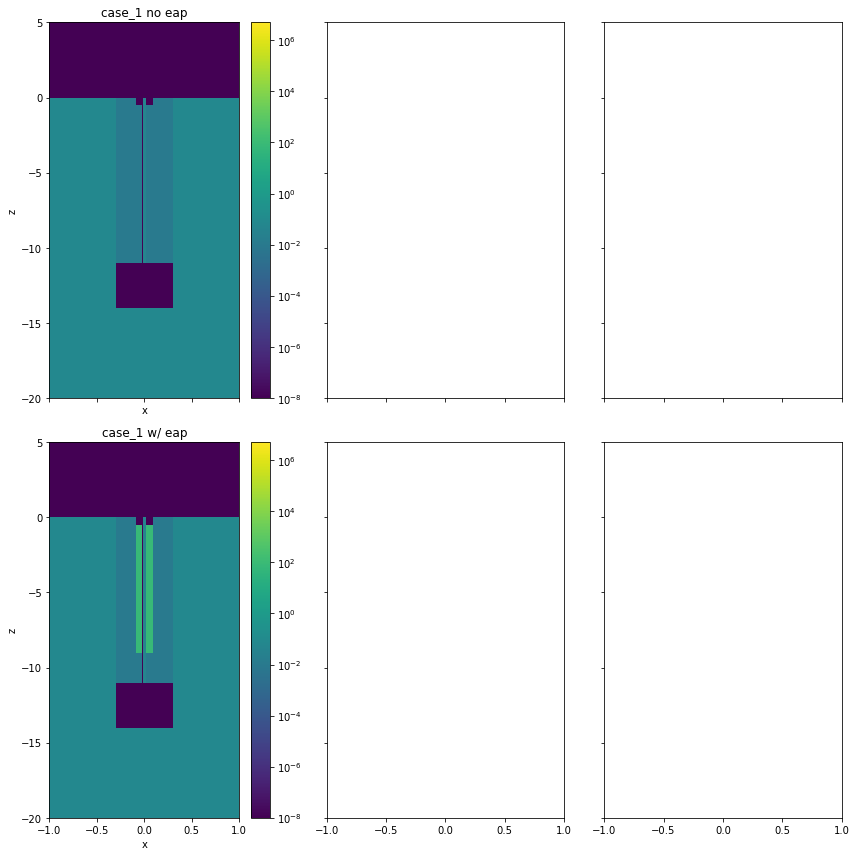

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(12, 12), sharex=True, sharey=True)

xlim = 1 * np.r_[-1, 1]
ylim = np.r_[-20, 5]

vmin = conductivity_values["very_resistive"]
vmax = 5e6 # conductivity_values["steel"]

plotme = (models_cement, models_cement_eap)

for i, key in enumerate(list(models_cement.keys())): 
    for j, m in enumerate([plotme[i][key], plotme[i+1][key]]): 
        cb = plt.colorbar(
            mesh.plot_image(
                m, ax=ax[j, i], mirror=True, pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)}
            )[0], ax=ax[j, i]
        )
        if i == 2: 
            cb.set_label("conductivity (S/m)")
        if j == 0: 
            ax[0, i].set_title(key + " no eap")
        elif j == 1: 
            ax[1, i].set_title(key + " w/ eap")
   

for a in ax.flatten(): 
    a.set_xlim(xlim)
    a.set_ylim(ylim)
plt.tight_layout()

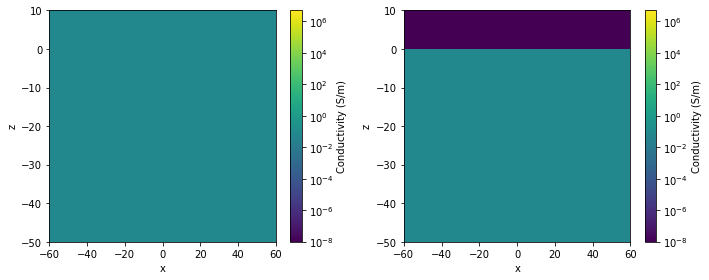

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

xlim = 60* np.r_[-1, 1]
ylim = np.r_[-50, 10]
 
for j, m in enumerate([model_wholespace, model_halfspace]): 
    cb = plt.colorbar(
        mesh.plot_image(
            m, ax=ax[j], mirror=True, pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)}
        )[0], ax=ax[j]
    )
    cb.set_label("Conductivity (S/m)")
# ax[0, i].set_title(key)

for a in ax.flatten(): 
    a.set_xlim(xlim)
    a.set_ylim(ylim)
plt.tight_layout()

In [25]:
case = "case_1"
def get_jsp(key): 
    jsp_z = np.zeros(mesh.n_faces_z)
    inds_jsp = (
        (mesh.faces_z[:, 0] > geometry["pvc_outer_radius"]) & 
        (mesh.faces_z[:, 0] < geometry["casing_inner_radius"]) &
        (mesh.faces_z[:, 2] < -geometry["surface_packer_thickness"]) &
        (mesh.faces_z[:, 2] > -cement_depth[case]) 
    )
    jsp_z[inds_jsp] = interp_dict[key](-mesh.faces_z[inds_jsp, 2])
    return np.r_[np.zeros(mesh.n_faces_x), jsp_z]


In [26]:
jsp = {key: get_jsp(key) for key in pore_pressure_cols} 

## set up the simulations

Here, we use a frequency of 0.1Hz

In [27]:
freq = 1e-1

def get_sim(case):
    src = fdem.sources.RawVec_e([], frequency=freq, s_e=jsp[case])
    survey = fdem.survey.Survey([src])
    return fdem.simulation.Simulation3DMagneticField(
        mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso
    )

simulations = {key: get_sim(key) for key in pore_pressure_cols}

### run the simulations

In [34]:
fields_cement = {}
fields_cement_eap = {}

fields_wholespace = {}
fields_halfspace = {}

key="case_1"
for case, sim in simulations.items(): 
    fields_cement[case] = sim.fields(models_cement[key])
    fields_cement_eap[case] = sim.fields(models_cement_eap[key])
    
    fields_wholespace[case] = sim.fields(model_wholespace)
    fields_halfspace[case] = sim.fields(model_halfspace)

### measure radial electric field data at the surface

In [35]:
dx = 2
surface_ex_inds = (
    (mesh.faces_x[:, 2] < 0) & (mesh.faces_x[:, 2] > -csz) & 
    (mesh.faces_x[:, 0] > dx)
)

surface_e_inds = np.r_[surface_ex_inds, np.zeros(mesh.n_faces_z, dtype=bool)]
x_data = mesh.nodes_x[mesh.nodes_x > dx]

In [36]:
# analytic solutions for wholespace 

def get_wholespace_solution(key): 
    inds_dipole = (
        (mesh.faces_z[:, 0] < csx) &
        (mesh.faces_z[:, 2] < -geometry["surface_packer_thickness"]) &
        (mesh.faces_z[:, 2] > -cement_depth["case_1"])
    )
    
    dipole_locations = np.c_[np.zeros(inds_dipole.sum()), np.zeros(inds_dipole.sum()), mesh.faces_z[inds_dipole, 2]]
    
    e_analytic = np.zeros_like(x_data, dtype=complex)
    area = np.pi * (geometry['casing_inner_radius']**2  - geometry['pvc_outer_radius']**2)
    for i in range(dipole_locations.shape[0]):
        edipole = geoana.em.fdem.ElectricDipoleWholeSpace(
            frequency=freq, location=dipole_locations[i, :], length=csz, current=interp_dict[key](-dipole_locations[i, 2])*area, 
            orientation="Z", sigma=conductivity_values["background"]
        )
        e_analytic = edipole.electric_field(np.c_[x_data, np.zeros_like(x_data), -csz/2*np.ones_like(x_data)])[:, 0] + e_analytic
    return e_analytic

In [37]:
e_analytic_wholespace = {
    key: get_wholespace_solution(key) for key in pore_pressure_cols
}

# plot results

Text(0.5, 1.0, 'Wholespace solutions')

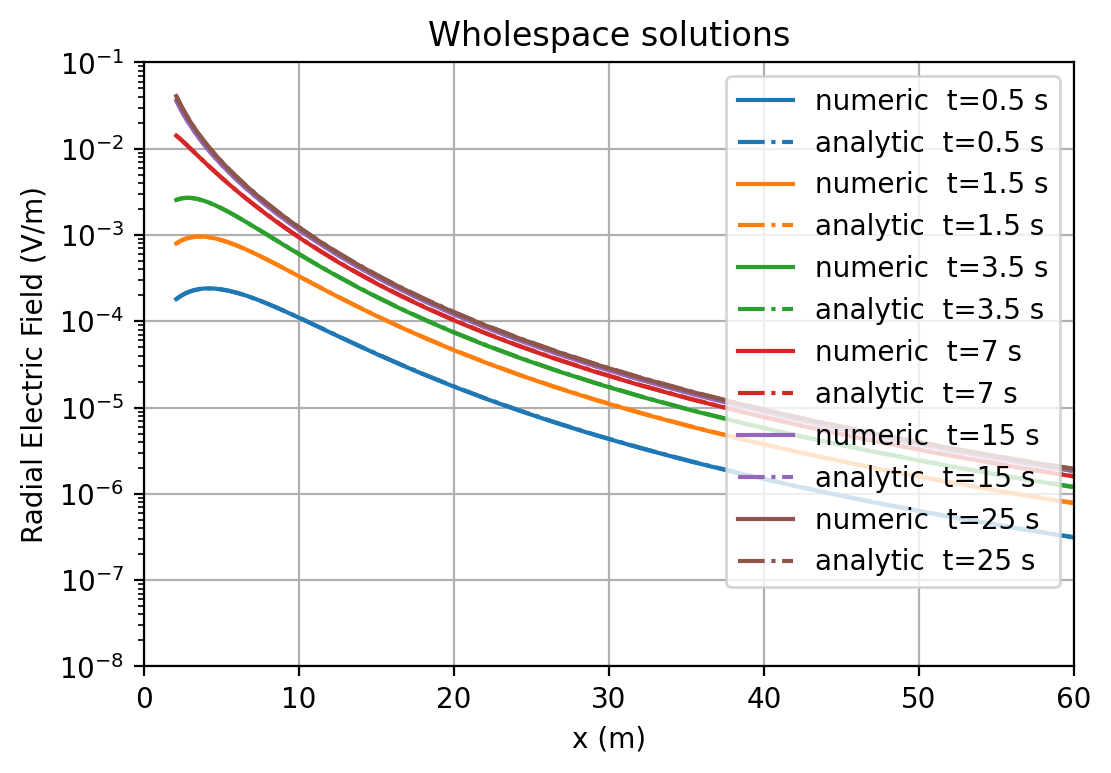

In [38]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-8, 1e-1]

for i, key in enumerate(e_analytic_wholespace.keys()):
    numeric = -fields_wholespace[key][:, "e"][surface_e_inds].flatten()
    analytic = -e_analytic_wholespace[key]
    ax.semilogy(x_data, numeric.real, color=f"C{i}", label=f"numeric {key.split(',')[-1]}")
    ax.semilogy(x_data, analytic.real, "-.", color=f"C{i}", label=f"analytic {key.split(',')[-1]}")
    # ax.semilogy(x_data, (analytic.real - numeric.real), ":", color=f"C{i}", label=f"difference {key}")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Radial Electric Field (V/m)")
ax.grid()
ax.legend()
ax.set_title("Wholespace solutions")


Text(0.5, 1.0, 'Wholespace solutions')

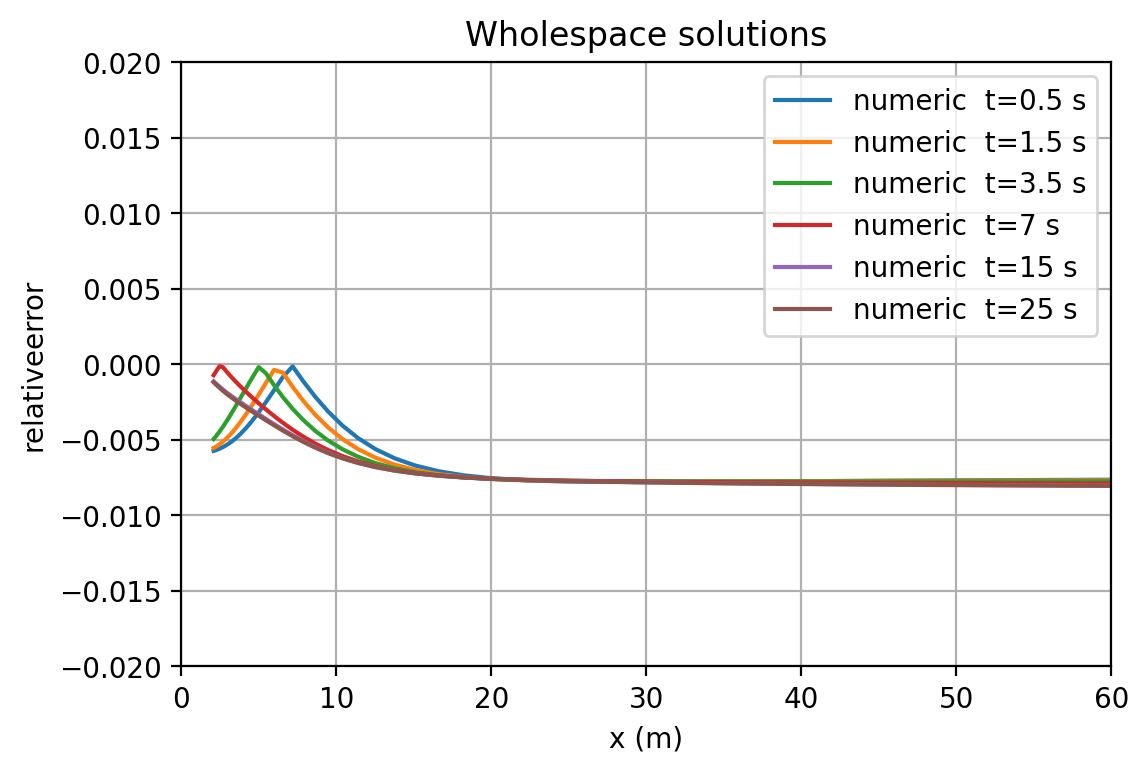

In [39]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-8, 9e-4]

for i, key in enumerate(e_analytic_wholespace.keys()):
    numeric = fields_wholespace[key][:, "e"][surface_e_inds].flatten()
    analytic = e_analytic_wholespace[key]
    ax.plot(x_data, np.abs(numeric.real-analytic.real)/analytic.real, color=f"C{i}", label=f"numeric {key.split(',')[-1]}")
ax.set_xlim(xlim)
ax.set_ylim([-0.02, 0.02])
ax.set_xlabel("x (m)")
ax.set_ylabel("relativeerror")
ax.grid()
ax.legend()
ax.set_title("Wholespace solutions")


Text(0.5, 1.0, 'Halfspace solutions')

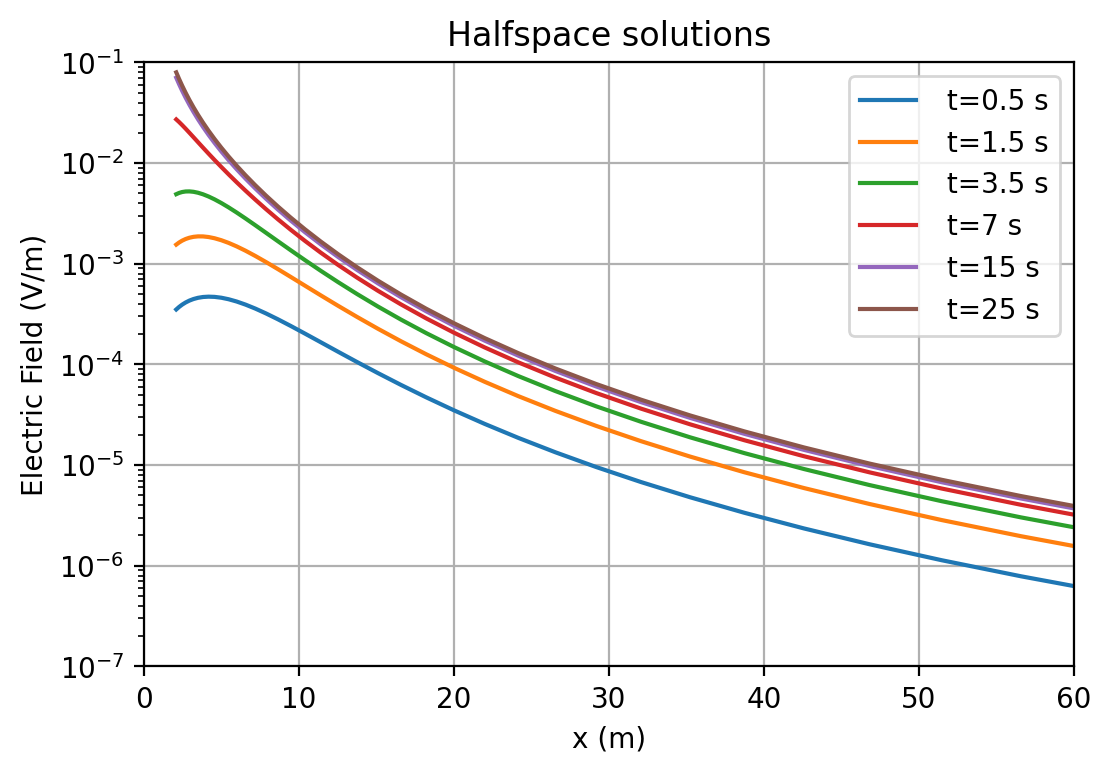

In [40]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-7, 1e-1]

for i, key in enumerate(fields_halfspace.keys()):
    numeric = fields_halfspace[key][:, "e"][surface_e_inds].flatten()
    ax.semilogy(x_data, -numeric.real, color=f"C{i}", label=f"{key.split(',')[-1]}")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Electric Field (V/m)")
ax.grid()
ax.legend()
ax.set_title("Halfspace solutions")

Text(0.5, 1.0, 'Casing models (1e-02 S/m)')

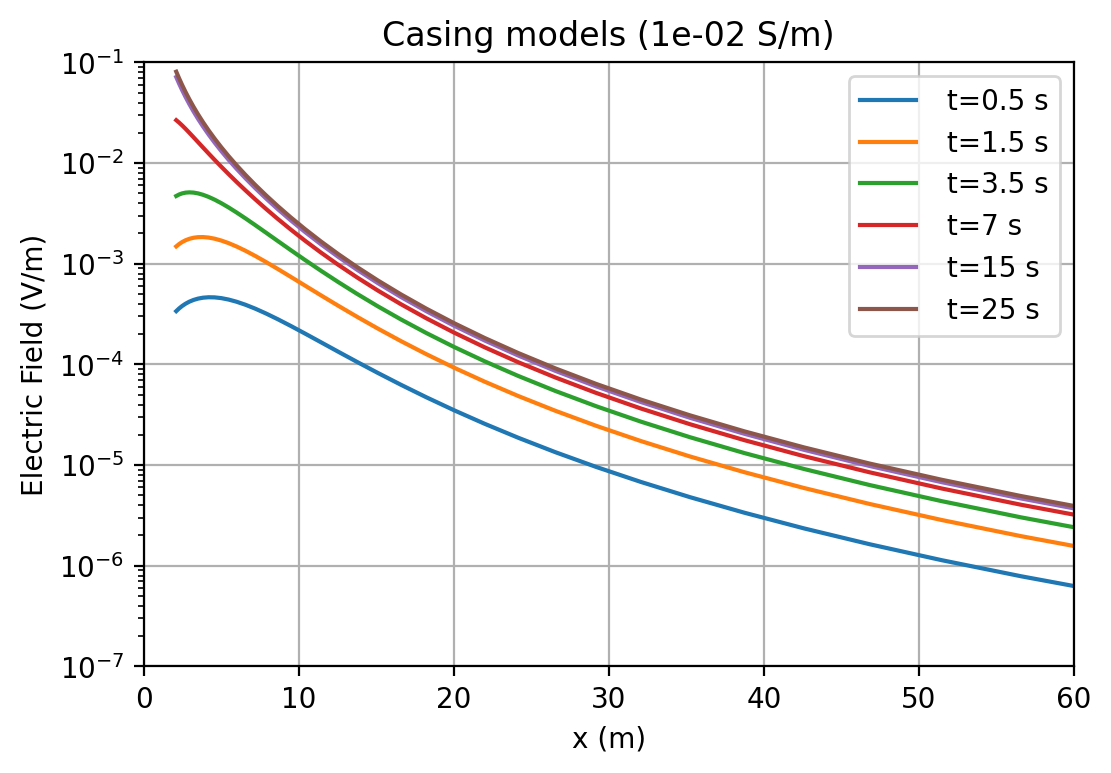

In [41]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-7, 1e-1]

i = 0
for key, val in fields_cement.items():
    ax.semilogy(x_data, np.abs(fields_cement[key][:, "e"][surface_e_inds].real), color=f"C{i}", label=f"{key.split(',')[-1]}")
    # ax.semilogy(x_data, np.abs(fields_cement_eap[key][:, "e"][surface_e_inds].real), "--", color=f"C{i}", label=f"{key.split(',')[-1]} w/ eap")
    i = i+1

ax.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Electric Field (V/m)")
ax.grid()
ax.set_title(f"Casing models ({conductivity_values['steel']:1.0e} S/m)")

In [ ]:
### measure data in an adjacent monitor well 

In [99]:
def get_borehole_inds(x_borehole, borehole_length=200): 
    ztop = -1
    borehole_ez_inds = (
        (mesh.faces_z[:, 0] < x_borehole + csx/2) & 
        (mesh.faces_z[:, 0] > x_borehole - csx/2) &
        (mesh.faces_z[:, 2] < ztop) & 
        (mesh.faces_z[:, 2] > -borehole_length)
    )
    borehole_e_inds = np.r_[
        np.zeros(mesh.n_faces_x, dtype=bool), borehole_ez_inds
    ]
    z_data = np.unique(mesh.faces_z[borehole_ez_inds, 2])
    print(np.unique(mesh.faces_z[borehole_ez_inds, 0]))
    return borehole_e_inds, z_data

In [100]:
x_inds_borehole = [174, 181] #, 186, 188, 191]  
borehole_x = mesh.cell_centers_x[x_inds_borehole]
label_vals = np.round(borehole_x, 0)
borehole_x, label_vals

(array([5.23530249, 9.94359808]), array([ 5., 10.]))

In [101]:
borehole_inds = []

for x in borehole_x: 
    inds, z_data = get_borehole_inds(x)
    borehole_inds.append(inds)


[5.23530249]
[9.94359808]


Text(0.5, 1.0, 'Borehole 10.0m')

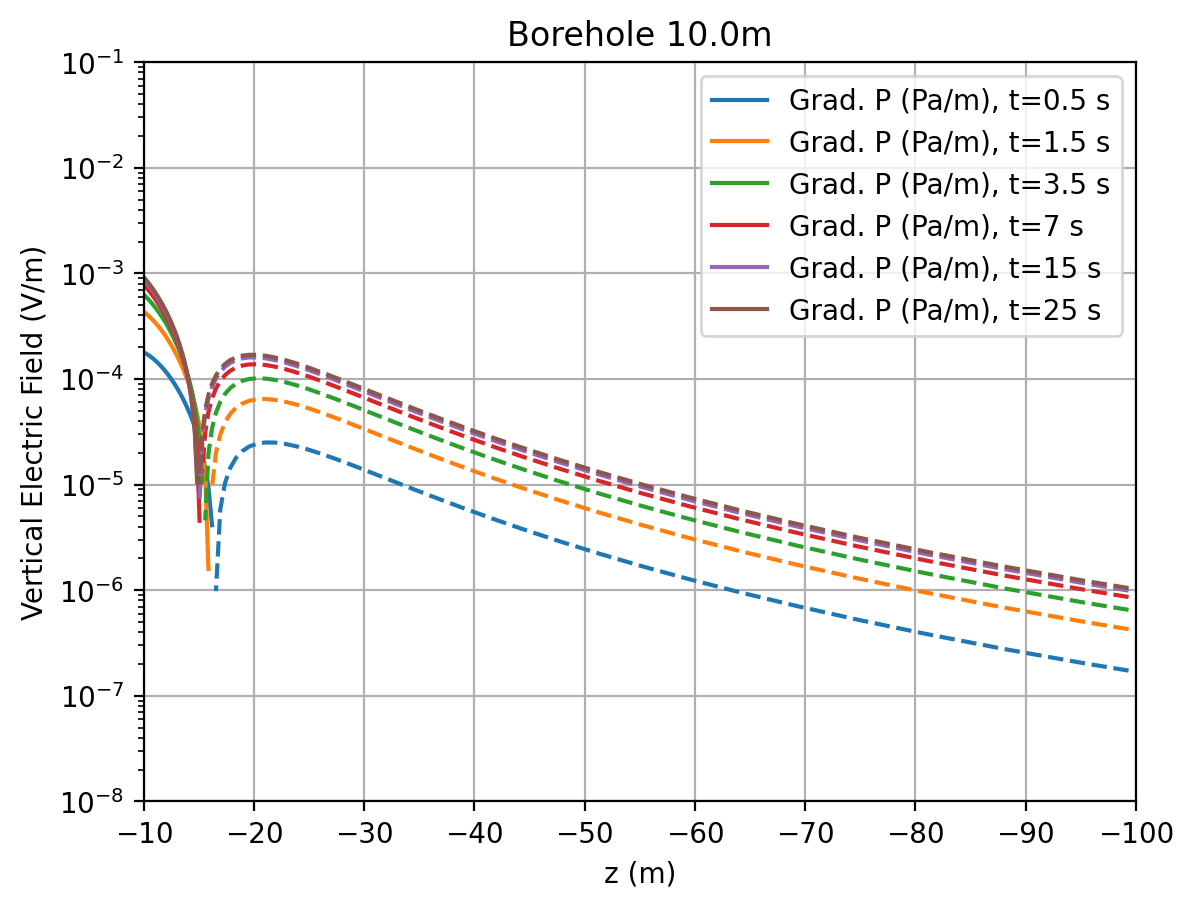

In [103]:
fig, ax = plt.subplots(1, 1, dpi=200)

bi = 1
xlim = np.r_[-10, -100]
ylim = np.r_[1e-8, 1e-1]
i=0

inds = borehole_inds[bi]
for key, val in fields_cement.items():
    numeric = val[:, "e"][inds].flatten().real 
    inds_pos = numeric > 0
    inds_neg = ~inds_pos
    ax.semilogy(z_data[inds_pos], numeric[inds_pos], color=f"C{i}", ls="-", label=key)
    ax.semilogy(z_data[inds_neg], np.abs(numeric[inds_neg]), color=f"C{i}", ls="--")
    i = i+1

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("z (m)")
ax.set_ylabel("Vertical Electric Field (V/m)")
ax.grid()
ax.legend()
ax.set_title(f"Borehole {label_vals[bi]}m")


In [104]:
# plot magnetic fields 

borehole_mag_inds = [54, 62]
length = 200 
# magnetic_field_r = mesh.nodes_x[mesh.nodes_x < geometry["pvc_inner_radius"]][-1]  # 1 cell outside of casing
magnetic_field_r = mesh.nodes_x[mesh.nodes_x > geometry["casing_outer_radius"]][borehole_mag_inds]  # 1 cell outside of casing

inds_magnetic_field_data = [(
    (mesh.edges_y[:, 0] == r) &
    (mesh.edges_y[:, 2] < 0) & 
    (mesh.edges_y[:, 2] > -length)
) for r in magnetic_field_r]

magnetic_field_z = mesh.nodes_z[
    (mesh.nodes_z < 0) & 
    (mesh.nodes_z > -length)
]

print(magnetic_field_r)

[ 4.99897856 10.40412656]


Text(0.5, 1.0, 'B$_y$ 10.0m')

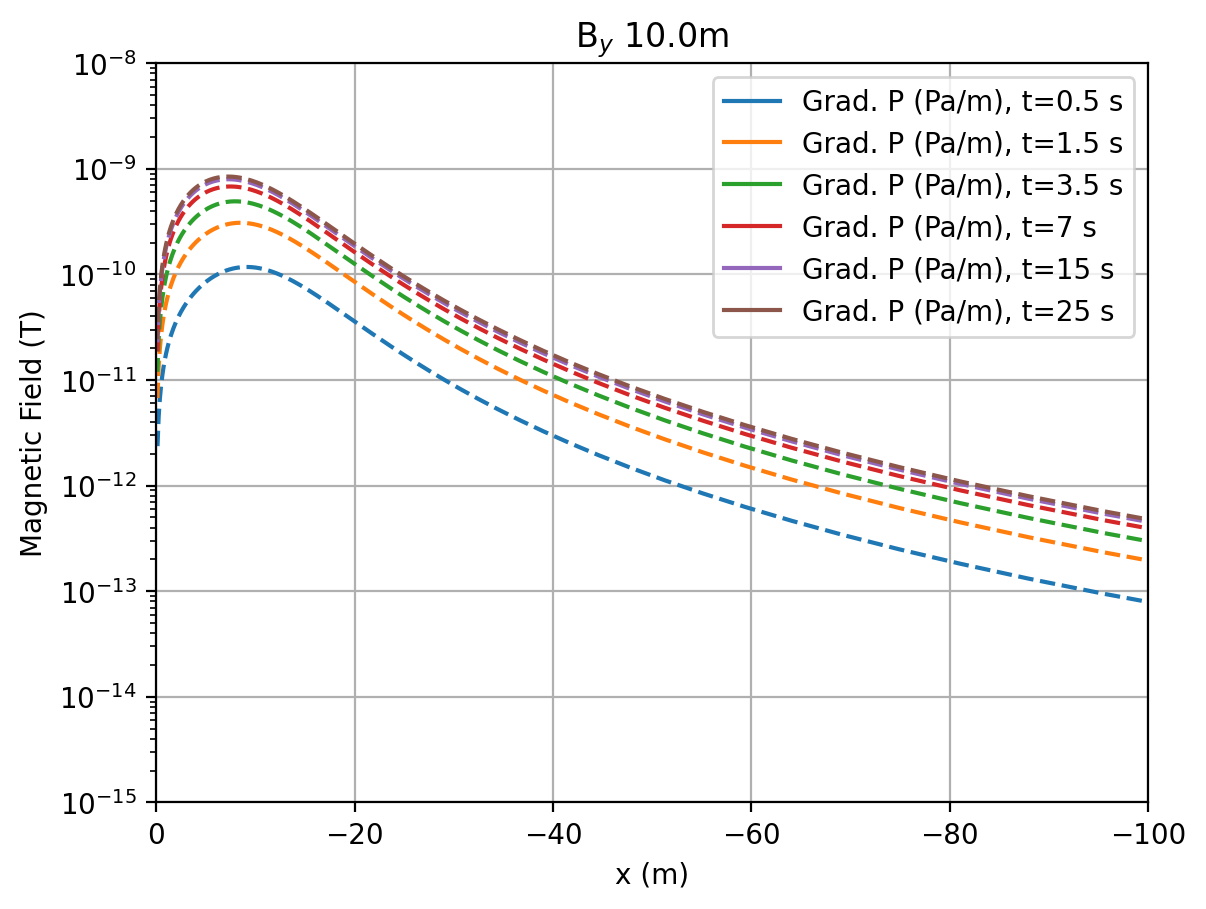

In [114]:
fig, ax = plt.subplots(1, 1, dpi=200)

bi = 1

xlim = np.r_[0, -100]
ylim = np.r_[1e-15, 1e-8]
inds = inds_magnetic_field_data[bi]
i=0 

for key, val in fields_cement.items():
    numeric = val[:, "b"][inds].flatten().real 
    inds_pos = numeric > 0
    inds_neg = ~inds_pos
    ax.semilogy(magnetic_field_z[inds_pos], numeric[inds_pos], color=f"C{i}", ls="-", label=key)
    ax.semilogy(magnetic_field_z[inds_neg], np.abs(numeric[inds_neg]), color=f"C{i}", ls="--")
    i = i+1
    
    # ax.semilogy(magnetic_field_z, np.abs(numeric.real), color=f"C{i}", label=f"{magnetic_field_r[i]:1.0f}m")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.invert_xaxis()
ax.set_xlabel("x (m)")
ax.set_ylabel("Magnetic Field (T)")
ax.grid()
ax.legend()
ax.set_title(f"B$_y$ {label_vals[bi]}m")

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-10, 9e-4]

i = 0
for key, val in fields_cement.items():
    ax.semilogy(x_data, np.abs(fields_cement_break[key][:, "e"][surface_e_inds].real), color=f"C{i}", label=f"{key.split(',')[-1]}")
    ax.semilogy(x_data, np.abs(fields_cement_break_eap[key][:, "e"][surface_e_inds].real), "--", color=f"C{i}", label=f"{key.split(',')[-1]} w/ eap")
    i = i+1

ax.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Electric Field (V/m)")
ax.grid()
ax.set_title(f"Broken Casing models ({-geometry['break_top']:1.0f} - {-geometry['break_bottom']:1.0f} m depth)")

In [ ]:
def plot_fields_cross_section(
    fields = (fields_cement, fields_cement_eap), 
    view = "j", 
    xlim = 0.3*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin= 1e-13,
    vmax = 1e-4,
    # primsec = "total", 
    ax=None
): 
    if ax is None: 
        fig, ax = plt.subplots(2, 6, figsize=(24, 12), sharex=True, sharey=True)
    
    sample_grid=np.r_[np.diff(xlim)/200., np.diff(ylim)/200.]
    
    for i, key in enumerate(list(fields[0].keys())): 
        for j, f in enumerate([fields[0][key], fields[1][key]]): 
    
            field_plot = f[:, view].real
            
            # if primsec.lower() in ["primary", "secondary"]:
            #     if j == 0: 
            #         primary_field = fields_cement_no_steel[key][:, view].real
            #     elif j == 1: 
            #         primary_field = fields_cement_eap_no_steel[key][:, view].real 
    
            #     if primsec.lower() == "primary":
            #         field_plot = primary_field
            #     elif primsec.lower() == "secondary": 
            #         field_plot = field_plot - primary_field
    
            if view in ["j", "e"]:
                field_plot = mesh.average_face_to_cell_vector * field_plot 
                pcolor_opts = {"norm":LogNorm(vmin=vmin, vmax=vmax)}
                vtype = "CCv"
            else: 
                if vmin is None and vmax is None: 
                    vmax = np.max(np.abs(field_plot))
                    vmin = -1*vmax
                pcolor_opts = {"norm":Normalize(vmin=vmin, vmax=vmax), "cmap":"RdBu_r"}
                vtype = None
                
    
            out = mesh.plot_image(
                field_plot, 
                v_type="CCv" if view in ["j", "e"] else "CC", 
                view="vec" if view in ["j", "e"] else "real", 
                ax=ax[j, i],
                range_x=xlim, range_y=ylim,
                sample_grid=sample_grid,
                mirror=True,
                pcolor_opts=pcolor_opts,
                stream_threshold=vmin,
                # stream_opts=stream_opts
            )
            cb = plt.colorbar(out[0], ax=ax[j, i])

            if view == "j":
                cb.set_label("current density (A/m$^2$)")
            elif view == "e": 
                cb.set_label("electric field (V/m)")
            elif view == "charge_density":
                cb.set_label("charge density (C/m$^32$)")
            
            if j == 0: 
                ax[j, i].set_title(f"{key}")
            elif j == 1: 
                ax[j, i].set_title(f"{key} w/ eap")
        plt.tight_layout()
    return ax

In [ ]:
ax = plot_fields_cross_section(
    view="j", 
    xlim = 0.3*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin= 1e-13,
    vmax = 1e-4,
)

In [ ]:
ax = plot_fields_cross_section(
    fields = (fields_halfspace, fields_halfspace), 
    view="e", 
    xlim = 0.3*np.r_[-1, 1],
    ylim = np.r_[-10, 0],
    vmin= 1e-8,
    vmax = 1e-2,
)

In [ ]:
ax = plot_fields_cross_section(
    fields = (fields_halfspace, fields_halfspace), 
    view="e", 
    xlim = 0.3*np.r_[-1, 1],
    ylim = np.r_[-10, 0],
    vmin= 1e-8,
    vmax = 1e-2,
)

In [ ]:
ax = plot_fields_cross_section(
    view="j", 
    xlim = 20*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin= 1e-10,
    vmax = 1e-4,
)

In [ ]:
ax = plot_fields_cross_section(
    fields=(fields_cement_break, fields_cement_break_eap),
    view="j", 
    xlim = 0.3*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin= 1e-13,
    vmax = 1e-4,
)

In [ ]:
ax = plot_fields_cross_section(
    fields = (fields_cement_no_steel, fields_cement_eap_no_steel),
    view="j", 
    xlim = 0.3*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin= 1e-13,
    vmax = 1e-4,
)

In [ ]:
ax = plot_fields_cross_section(
    view="e", 
    xlim = 0.3*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin= 1e-11,
    vmax = 1e-2,
)

In [ ]:
ax = plot_fields_cross_section(
    fields=(fields_cement_break, fields_cement_break_eap),
    view="e", 
    xlim = 0.3*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin= 1e-11,
    vmax = 1e-2,
)

In [ ]:
vmax = 1e-17
ax = plot_fields_cross_section(
    view="charge_density", 
    xlim = 0.3*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin = vmax,
    vmax = -vmax,
)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(17, 6))
ax = plot_fields_cross_section(
    view="j", 
    xlim = 60*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin= 1e-13,
    vmax = 1e-7,
    ax=ax
)

for a in ax.flatten():
    a.set_aspect(1)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(17, 6))
ax = plot_fields_cross_section(
    view="e", 
    xlim = 60*np.r_[-1, 1],
    ylim = np.r_[-50, 5],
    vmin= 1e-12,
    vmax = 1e-5,
    ax=ax
)

for a in ax.flatten():
    a.set_aspect(1)